<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Filters

## 前準備

[matplotlib - List of named colors](https://matplotlib.org/stable/gallery/color/named_colors.html#tableau-palette)

In [1]:
from matplotlib.colors import TABLEAU_COLORS

BLUE = TABLEAU_COLORS["tab:blue"]
ORANGE = TABLEAU_COLORS["tab:orange"]
GREEN = TABLEAU_COLORS["tab:green"]
RED = TABLEAU_COLORS["tab:red"]
PURPLE = TABLEAU_COLORS["tab:purple"]

## 使用する運動モデル

円運動モデル
\begin{equation}
\begin{pmatrix}
x \\ y
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta \\
\sin\theta
\end{pmatrix}
\end{equation}

In [2]:
import numpy as np

DT = 2 * np.pi / 100

def create_points():
    t = np.arange(0, 2*np.pi, DT)
    x = np.sin(t)
    y = np.cos(t)
    points = np.vstack((x, y)).T
    return points

points = create_points()

<ipython-input-3-01bde3f44ed3>:21: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cur_pos_plt.set_data(points[i, 0], points[i, 1])


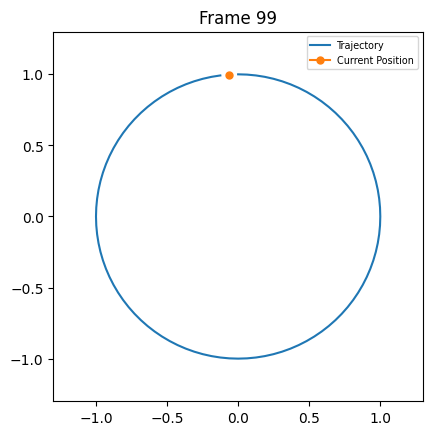

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def traj_anim(points):
    fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)

    traj_plt, = ax.plot([], [], c=BLUE, label="Trajectory")
    cur_pos_plt, = ax.plot(
        [], [], c=ORANGE, marker="o", markersize=5,
        label="Current Position")
    ax.legend(loc="upper right", fontsize="x-small")

    def anim_callback(i):
        ax.set_title(f"Frame {i}")
        traj_plt.set_data(points[:i, 0], points[:i, 1])
        cur_pos_plt.set_data(points[i, 0], points[i, 1])

    ani = animation.FuncAnimation(fig, anim_callback, frames=points.shape[0])
    ani.save("move.gif", writer="pillow")

traj_anim(points)

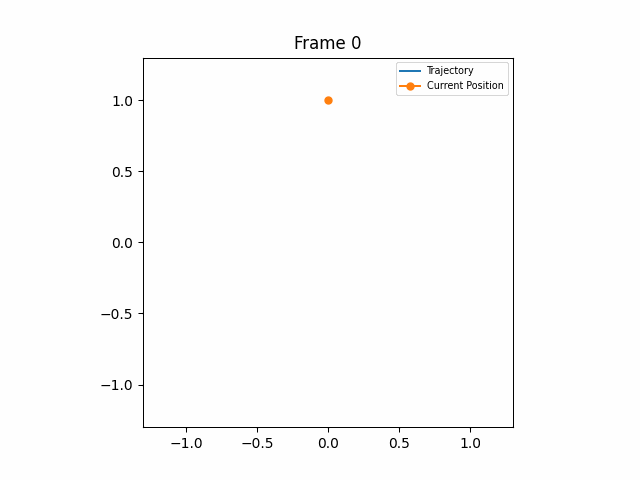

In [4]:
import IPython
from IPython.display import Image

# アニメーション再生
Image("./move.gif", format='png')

## EKF

EKF は非線形運動モデルを線形近似して Kalman Filter を適用するだけ。

今回の EKF での運動モデルの近似式は次の通り。
\begin{equation}
\begin{pmatrix}
x_{k+1} \\ y_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta_{k+1} \\ \sin\theta_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
\cos(\theta_k+\delta\theta) \\ \sin(\theta_k+\delta\theta)
\end{pmatrix}
=
\begin{pmatrix}
1 & -\delta\theta \\
\delta\theta & 1
\end{pmatrix}
\begin{pmatrix}
x_k \\ y_k
\end{pmatrix}
+\frac{1}{2}
\begin{pmatrix}
 \cos\theta_0\delta\theta^2 \\
 \sin\theta_0\delta\theta^2
\end{pmatrix}
+\mathcal{O}(\delta\theta^3)
\end{equation}

誤差絶対値の上限値を用いて次の近似をする。
\begin{equation}
\begin{pmatrix}
x_{k+1} \\ y_{k+1}
\end{pmatrix}
\simeq
\begin{pmatrix}
1 & -\delta\theta \\
\delta\theta & 1
\end{pmatrix}
\begin{pmatrix}
x_k \\ y_k
\end{pmatrix}
+w_k,\quad
w_k\sim N\left(0,\frac{1}{2}\delta\theta^2I\right)
\end{equation}

観測モデルは$(x,y)$変数の多変量正規分布とする。
\begin{equation}
\begin{pmatrix}
x_k' \\ y_k'
\end{pmatrix}
=
\begin{pmatrix}
x_k \\ y_k
\end{pmatrix}
+ v_k,\quad
v_k\sim N(0,\sigma^2 I)
\end{equation}

Kalman Filter の公式は[ここ](https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%AB%E3%83%9E%E3%83%B3%E3%83%95%E3%82%A3%E3%83%AB%E3%82%BF%E3%83%BC)を参照。

In [5]:
NOISE_SIGMA = 0.4

def predict_state(state: np.ndarray, state_error: np.ndarray):
    """"
    運動モデルから予測状態・誤差を計算
    """
    # 状態予測
    f_mat = np.array([[1, -DT], [DT, 1]])
    pred_state = state @ f_mat

    # 誤差計算
    q_mat = np.array([[0.5*DT**2, 0], [0, 0.5*DT**2]])
    pred_state_error = f_mat @ state_error @ f_mat.T + q_mat

    return pred_state, pred_state_error

def kalman_state(
        state: np.ndarray,
        state_error: np.ndarray,
        observation: np.ndarray):
    """"
    カルマンフィルタから予測状態・誤差を計算
    """
    pred_state, pred_state_error = predict_state(state, state_error)

    # カルマンゲインを計算
    r_mat = np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])
    s_mat = r_mat + pred_state_error
    kalman_gain = pred_state_error @ np.linalg.inv(s_mat)

    # 状態予測
    innovation = observation - pred_state
    joint_state = pred_state + kalman_gain @ innovation

    # 誤差計算
    joint_state_error = (np.eye(2) - kalman_gain) @ pred_state_error
    return joint_state, joint_state_error

In [6]:
def create_obs(points):
    noise = np.random.normal(0, NOISE_SIGMA**2, (points.shape[0], 2))
    points_obs = points + noise
    return points_obs

points_obs = create_obs(points)

EKF 実行

In [7]:
def ekf_integrate(points_obs):
    # 初期状態作成
    init_state = points_obs[0, :]
    init_state_error =np.array([[NOISE_SIGMA**2, 0], [0, NOISE_SIGMA**2]])

    # 予測状態・カルマンフィルタ後の状態を初期化
    pred_state = [init_state]
    pred_state_error = [init_state_error]
    joint_state = [init_state]
    joint_state_error = [init_state_error]

    # 逐次ステップ計算
    for i in range(0, points_obs.shape[0]-1):
        # 運動モデル
        state, state_error = predict_state(
            state=pred_state[i],
            state_error=pred_state_error[i])
        pred_state.append(state)
        pred_state_error.append(state_error)

        # カルマンフィルタ
        state, state_error = kalman_state(
            state=joint_state[i],
            state_error=joint_state_error[i],
            observation=points_obs[i+1, :])
        joint_state.append(state)
        joint_state_error.append(state_error)

    # np.ndarray に変換
    pred_state = np.vstack(pred_state)
    pred_state_error = np.dstack(pred_state_error)
    joint_state = np.vstack(joint_state)
    joint_state_error = np.dstack(joint_state_error)

    return pred_state, pred_state_error, joint_state, joint_state_error

In [8]:
def cov2ellipse(cov: np.ndarray):
    eig_val, eig_vec = np.linalg.eigh(cov)
    angle = np.arctan2(eig_vec[1, 0], eig_vec[0, 0])
    width = np.sqrt(eig_val[0])
    height = np.sqrt(eig_val[1])
    return width, height, angle

<ipython-input-9-7c0bbc9a7cfe>:40: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  gt_pos_plt.set_data(points[i, 0], points[i, 1])
<ipython-input-9-7c0bbc9a7cfe>:45: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pred_pos_plt.set_data(pred_state[i, 0], pred_state[i, 1])
<ipython-input-9-7c0bbc9a7cfe>:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  kalman_pos_plt.set_data(joint_state[i, 0], joint_state[i, 1])


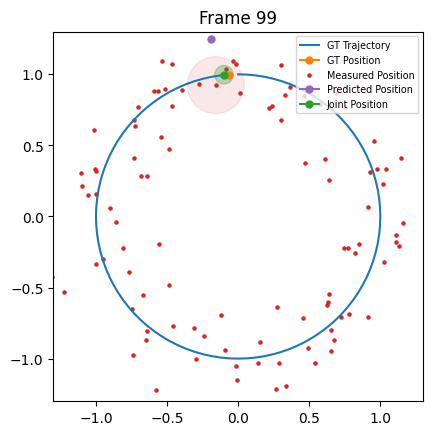

In [9]:
from matplotlib.patches import Ellipse

def ekf_anim(points, points_obs):
    pred_state, pred_state_error, joint_state, joint_state_error = ekf_integrate(points_obs)

    x = points_obs[:, 0]
    y = points_obs[:, 1]

    fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)

    gt_traj_plt, = ax.plot([], [], c=BLUE, label="GT Trajectory")
    gt_pos_plt, = ax.plot(
        [], [], c=ORANGE, marker="o", markersize=5, label="GT Position")

    obs_pos_scat = ax.scatter([], [], s=5, c=RED, label="Measured Position")
    obs_ellipse = Ellipse(
        xy=(0, 1), width=NOISE_SIGMA, height=NOISE_SIGMA, angle=0,
        color=RED, alpha=0.1, animated=True)
    ax.add_patch(obs_ellipse)

    pred_pos_plt, = ax.plot(
        [], [], c=PURPLE, marker="o", markersize=5, label="Predicted Position")
    kalman_pos_plt, = ax.plot(
        [], [], c=GREEN, marker="o", markersize=5, label="Joint Position")
    kalman_ellipse = Ellipse(
        xy=(0, 1), width=NOISE_SIGMA, height=NOISE_SIGMA, angle=0,
        color=GREEN, alpha=0.3, animated=True)
    ax.add_patch(kalman_ellipse)

    ax.legend(loc="upper right", fontsize="x-small")

    def anim_callback(i):
        ax.set_title(f"Frame {i}")

        gt_traj_plt.set_data(points[:i+1, 0], points[:i+1, 1])
        gt_pos_plt.set_data(points[i, 0], points[i, 1])

        obs_pos_scat.set_offsets(points_obs[:i+1, :])
        obs_ellipse.set_center(points_obs[i, :])

        pred_pos_plt.set_data(pred_state[i, 0], pred_state[i, 1])
        kalman_pos_plt.set_data(joint_state[i, 0], joint_state[i, 1])

        width, height, angle = cov2ellipse(joint_state_error[:, :, i])
        kalman_ellipse.set_center([joint_state[i, 0], joint_state[i, 1]])
        kalman_ellipse.set_width(width)
        kalman_ellipse.set_height(height)
        kalman_ellipse.set_angle(angle)

    ani = animation.FuncAnimation(fig, anim_callback, frames=len(x))
    ani.save("ekf.gif", writer="pillow")

ekf_anim(points, points_obs)

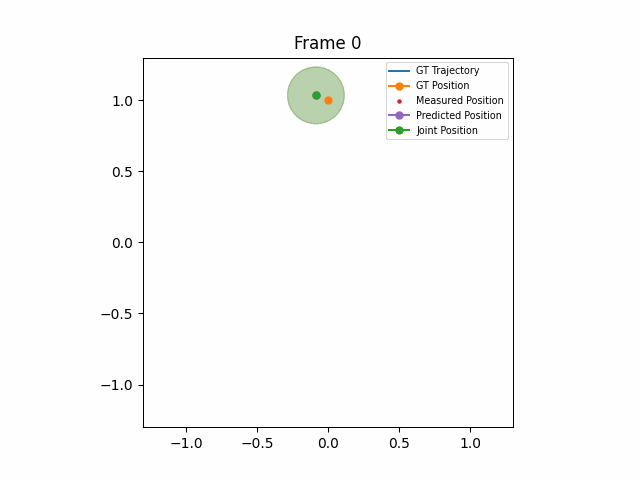

In [10]:
Image("./ekf.gif", format='png')

## UKF